In [1]:
import tensorflow as tf
import numpy as np
import os
import ast
import abc
import random
from typing import List, Dict, Union, Tuple
import numpy as np
from scipy.stats import truncnorm
import argparse
import timeit
from datetime import datetime
import matplotlib.pyplot as plt
# from tensorflow_addons.layers.nalu import NALU
%load_ext tensorboard

os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # disable cuda sepeed up
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' # disable CPU wornings

2022-11-09 15:30:43.862599: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-09 15:30:43.862652: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
parser = argparse.ArgumentParser()
parser.add_argument("-o", "--output", dest="output", default="naly_syn_simple_arith")
parser.add_argument("-d", "--dist", dest="dist", default="normal", help="Prob.Dist")
parser.add_argument("-p", "--params",dest="params" , default="(-3,3)", type=ast.literal_eval)
parser.add_argument("-e", "--ext",dest="ext" , default="(10,15)", type=ast.literal_eval)

parser.add_argument("-n", "--nalu", dest="nalu", default="nalui1")
parser.add_argument("-se", "--seed", dest="seed", default=42, type=int)
parser.add_argument("-op", "--operation", dest="op", default="MUL")



args = parser.parse_args([])

def operation(op, a, b):
    if op.lower() == "mul":
        return a * b
    if op.lower() == "add":
        return a + b
    if op.lower() == "sub":
        return a - b
    if op.lower() == "div":
        return a / b


BATCH_SIZE = 64

w, m, g = np.load("w.npy"), np.load("m.npy"), np.load("g.npy")
data, int_data, ext_data = np.load("data.npy"), np.load("int_data.npy"), np.load("ext_data.npy")
lbls = operation(args.op, data[:,0], data[:,1])
lbls = np.reshape(lbls, newshape=(-1, 1))

int_lbls = operation(args.op, int_data[:,0], int_data[:,1])
int_lbls = np.reshape(int_lbls, newshape=(-1, 1))


ext_lbls = operation(args.op, ext_data[:,0], ext_data[:,1])
ext_lbls = np.reshape(ext_lbls, newshape=(-1, 1))

losses = np.load("losses.npy")
rlosses = np.load("rlosses.npy")
ext_loss = np.load("ext_loss.npy")
int_loss = np.load("int_loss.npy")
rext_loss = np.load("rext_loss.npy")
rint_loss = np.load("rint_loss.npy")


data_dp = tf.data.Dataset.from_tensor_slices((data, lbls)).prefetch(tf.data.AUTOTUNE).batch(BATCH_SIZE)
int_data_dp = tf.data.Dataset.from_tensor_slices((int_data, int_lbls)).prefetch(tf.data.AUTOTUNE).batch(BATCH_SIZE)
ext_data_dp = tf.data.Dataset.from_tensor_slices((ext_data, ext_lbls)).prefetch(tf.data.AUTOTUNE).batch(BATCH_SIZE)



2022-11-09 15:30:50.934099: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-09 15:30:50.934158: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-09 15:30:50.934189: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (filip-HP-ProBook-440-G3): /proc/driver/nvidia/version does not exist
2022-11-09 15:30:50.935288: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
BATCH_SIZE = 64

data_dp = tf.data.Dataset.from_tensor_slices((data, lbls)).prefetch(tf.data.AUTOTUNE).batch(BATCH_SIZE)
int_data_dp = tf.data.Dataset.from_tensor_slices((int_data, int_lbls)).prefetch(tf.data.AUTOTUNE).batch(BATCH_SIZE)
ext_data_dp = tf.data.Dataset.from_tensor_slices((ext_data, ext_lbls)).prefetch(tf.data.AUTOTUNE).batch(BATCH_SIZE)

In [229]:
# Copyright 2020 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# =====================================================epoch
import tensorflow as tf
from typeguard import typechecked
from typing import List
from tensorflow_addons.utils import types


class NALURegularizer(tf.keras.regularizers.Regularizer):
    def __init__(self, reg_coef=0.1):
        self.reg_coef = reg_coef

    def __call__(self, var: List[tf.Variable]) -> tf.Tensor:
        return self.reg_coef * tf.add_n([tf.reduce_mean(tf.math.maximum(tf.math.minimum(-v, v) + 20, 0)) for v in var])

    def get_config(self):
        return {"reg_coef": float(self.reg_coef)}


# @tf.keras.utils.register_keras_serializable(package="Addons")
class NALU(tf.keras.layers.Layer):
    r"""Neural Arithmetic Logic Units

    A layer that learns addition,substraction, multiplication and division 
    in transparent way. They layer has two paths: one for addition/substration 
    and one for multiplication/division. We can inspect weights for these two
    paths by calling `w_hat` and `m_hat` respectively. To use this layer reliably, 
    we have to delay regularization of gating varaible that switch between two paths.
    Ithave to be done by callback as from the layer-level we keep no information about epochs.


    See [Neural Arithmetic Logic Units](https://arxiv.org/abs/1808.00508)
    and [Improved Neural Arithmetic Logic Unit](https://arxiv.org/abs/2003.07629) 


    Example:

    >>> BATCH_SIZE, INPUT_SIZE, OUTPUT_SIZE = 16, 5, 2
    >>> input = tf.random.uniform((BATCH_SIZE, INPUT_SIZE))
    >>> nalu_layer = NALU(OUTPUT_SIZE)
    >>> predict = nalu_layer(input)
    >>> assert predict.shape == (BATCH_SIZE, OUTPUT_SIZE)

    Args:
        input_dim (int): input 
        output_dim (int): _description_
        regularizer (types.Regularizer, optional): _description_. Defaults to NALURegularizer(reg_coef=0.05).
        gate_as_vector (bool, optional): _description_. Defaults to True.
        clipping (float, optional): _description_. Defaults to None.
        force_operation (str, optional): _description_. Defaults to None.
        weights_separation (bool, optional): _description_. Defaults to True.
        input_gate_dependance (bool, optional): _description_. Defaults to True.
        w_initializer (types.Initializer, optional): _description_. Defaults to tf.random_normal_initializer( mean=0.88, stddev=0.2, seed=None ).
        m_initializer (types.Initializer, optional): _description_. Defaults to tf.random_normal_initializer( mean=0.5, stddev=0.2, seed=None ).
        g_initializer (types.Initializer, optional): _description_. Defaults to tf.random_normal_initializer( mean=0.0, stddev=0.2, seed=None ).
    """

   
            
    
    class Superc(tf.keras.callbacks.Callback):
        
        def __init__(self, 
            ext_data, ext_label,
            int_data, int_label,
            epochs_to_reg: int = 8, 
            lt_to_reg: float = 1.0, 
            fr_param_check: int = 10000,
            # param_check_verbose: int = 0
            *args, **kwargs):

            
            super(NALU.Superc, self).__init__(*args, **kwargs)
            NALU.Superc.epochs_to_reg = epochs_to_reg
            NALU.Superc.lt_to_reg = lt_to_reg
            NALU.Superc.fr_param_check = fr_param_check
            self.ext_data = ext_data
            self.ext_label = ext_label
            self.int_data = int_data
            self.int_label = int_label
            # self.param_check_verbose = param_check_verbose

        def on_train_begin(self, logs = None):
            NALU.Superc.reinit_history = []
            NALU.Superc.reinit_counter = 0
            NALU.Superc._steps_counter = 0
            NALU.Superc._epoch_counter = 0
            NALU.Superc.ext_res = []
            NALU.Superc.int_res = []

            NALU.Superc.gate_counter = 0
            NALU.Superc.gate_history = []


        # delay regularize
        def on_epoch_end(self, epoch, logs = None):
            NALU.Superc._epoch_counter += 1


        def on_train_batch_end(self, batch, logs = None):
            
            NALU.Superc._steps_counter += 1
            
            # record last loss
            NALU.Superc.reinit_history.append(logs.get("loss"))

            # train either active or gating
            self.model.gating.assign(NALU.Superc._steps_counter % 10 > 8)
            NALU.Superc.gate_history.append(self.model.gating.numpy())
            if NALU.Superc._steps_counter % 10 > 8:
                NALU.Superc.gate_counter += 1


            # turn on or of ragularization depending on epoch number and last seen loss

            self.model.regularize.assign(NALU.Superc._epoch_counter > NALU.Superc.epochs_to_reg and NALU.Superc.reinit_history[-1] < NALU.Superc.lt_to_reg)


            # reinitialisation strategy
            split_index = len(NALU.Superc.reinit_history)//2
            if len(NALU.Superc.reinit_history)>10000 \
                and NALU.Superc._epoch_counter > 0 \
                and NALU.Superc._epoch_counter%10==1 \
                and tf.math.reduce_mean(NALU.Superc.reinit_history[:split_index]) <= tf.math.add(
                            tf.math.reduce_mean(NALU.Superc.reinit_history[split_index:]),
                            tf.math.reduce_std(NALU.Superc.reinit_history[split_index:])
                            ) \
                and tf.math.reduce_mean(NALU.Superc.reinit_history[split_index:]) > 1:
                # reinitialize all nalu layers 
                self.model.reinitialise()
                NALU.Superc.reinit_history = []
                NALU.Superc.reinit_counter += 1

            # check parameters
            if self._steps_counter % NALU.Superc.fr_param_check == 0:
                eloss_ex = self.model.compiled_loss._losses[0](self.model.predict(self.ext_data, verbose = 0), self.ext_label)
                eloss_in = self.model.compiled_loss._losses[0](self.model.predict(self.int_data, verbose = 0), self.int_label)
                NALU.Superc.ext_res.append(eloss_ex)
                NALU.Superc.int_res.append(eloss_in)



    @typechecked
    def __init__(
        self,
        input_dim: int,
        output_dim: int,
        regularizer: types.Regularizer = NALURegularizer(reg_coef=0.05),
        gate_as_vector: bool = True,
        clipping: float = None,
        force_operation: str = None,
        weights_separation: bool = False,
        input_gate_dependance: bool = True,
        w_initializer: types.Initializer = tf.random_normal_initializer(
            mean=1., stddev=0.1, seed=None
        ),
        m_initializer: types.Initializer = tf.random_normal_initializer(
            mean=-1., stddev=0.1, seed=None
        ),
        g_initializer: types.Initializer = tf.random_normal_initializer(
            mean=0.0, stddev=0.1, seed=None
        ),
        *args,
        **kwargs,
    ):
        super(NALU, self).__init__(*args, **kwargs)

        self.reg_fn = regularizer
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.gate_as_vector = gate_as_vector
        self.clipping = clipping
        self.force_operation = force_operation
        self.weights_separation = weights_separation
        self.input_gate_dependance = input_gate_dependance
        self.w_initializer = w_initializer
        self.m_initializer = m_initializer
        self.g_initializer = g_initializer

        self.operator_weight_shape = (self.input_dim, self.output_dim) if self.gate_as_vector else (self.output_dim, self.input_dim)
        self.gate_shape = (self.input_dim, self.output_dim if self.gate_as_vector else 1) if self.input_gate_dependance else (self.output_dim,)

        # self.w_hat = tf.Variable(self.w_initializer(shape = self.operator_weight_shape), trainable = True, name = "w")
        # self.m_hat = tf.Variable(self.m_initializer(shape = self.operator_weight_shape), trainable = True, name = "m")
        # self.g = tf.Variable(self.g_initializer(shape = self.gate_shape), trainable = False, name = "w")
        
        # action variables
        self.w_hat = tf.Variable(w, trainable=True)

        self.m_hat = tf.Variable(m, trainable=True)

        # gating varaible
        self.g = tf.Variable(g, trainable=False)
        
        self.w_hat_prime = tf.Variable(self.w_initializer(shape = self.operator_weight_shape), trainable = True, name = "wprime") if self.weights_separation else None
        self.m_hat_prime = tf.Variable(self.m_initializer(shape = self.operator_weight_shape), trainable = True, name = "mprime") if self.weights_separation else None

    #@tf.function
    def get_reg_loss(self):
        var_list = [self.w_hat, self.m_hat, self.g] 
        if self.weights_separation:
            var_list += [self.w_hat_prime, self.m_hat_prime]
        return self.reg_fn(var_list)


    def call(self, input):
        eps = 1e-7
        w1 = tf.math.tanh(self.w_hat) * tf.math.sigmoid(self.m_hat)
        a1 = tf.matmul(input, w1)

        m1 = tf.math.exp(tf.minimum(tf.matmul(tf.math.log(tf.maximum(tf.math.abs(input), eps)),w1), 20))
        
        # sign
        w1s = tf.math.abs(tf.reshape(w1, [-1]))
        xs = tf.concat([input] * w1.shape[1], axis=1)
        xs = tf.reshape(xs, shape=[-1, w1.shape[0] * w1.shape[1]])
        sgn = tf.sign(xs) * w1s + (1 - w1s)
        sgn = tf.reshape(sgn, shape=[-1, w1.shape[1], w1.shape[0]])
        ms = tf.math.reduce_prod(sgn, axis=2)
        
        g1 = tf.math.sigmoid(self.g)

        # add reg loss
        self.add_loss(self.get_reg_loss())

        return g1 * a1 + (1 - g1) * m1 * tf.clip_by_value(ms, -1, 1)

    def reinitialise(self):
        self.g.assign(tf.random.uniform(self.g.shape, -2, 2))
        self.w_hat.assign(tf.random.uniform(self.w_hat.shape, -2, 2))
        self.m_hat.assign(tf.random.uniform(self.m_hat.shape, -2, 2))
        if self.weights_separation:
            self.w_hat_prime.assign(tf.random.uniform(self.w_hat_prime.shape, -2, 2))
            self.m_hat_prime.assign(tf.random.uniform(self.m_hat_prime.shape, -2, 2))


    def get_gates_variables(self) -> List[tf.Variable]:
        return [self.g]

In [259]:

# # @tf.keras.utils.register_keras_serializable(package="Addons")
# class NALU(tf.keras.layers.Layer):
#     """Simplified NALU class to demonstrate lr problem."""

#     @typechecked
#     def __init__(
#         self,
#         input_dim: int,
#         output_dim: int,
#         w, m, g,
#         *args,
#         **kwargs,
#     ):
#         super(NALU, self).__init__(*args, **kwargs)

#         self.input_dim = input_dim
#         self.output_dim = output_dim
        

#         # action variables
#         self.w_hat = tf.Variable(w, trainable=True)

#         self.m_hat = tf.Variable(m, trainable=True)

#         # gating varaible
#         self.g = tf.Variable(g, trainable=False)

#     def call(self, input):
#         eps = 1e-7
#         w1 = tf.math.tanh(self.w_hat) * tf.math.sigmoid(self.m_hat)
#         a1 = tf.matmul(input, w1)

#         m1 = tf.math.exp(tf.minimum(tf.matmul(tf.math.log(tf.maximum(tf.math.abs(input), eps)),w1), 20))
        
#         # sign
#         w1s = tf.math.abs(tf.reshape(w1, [-1]))
#         xs = tf.concat([input] * w1.shape[1], axis=1)
#         xs = tf.reshape(xs, shape=[-1, w1.shape[0] * w1.shape[1]])
#         sgn = tf.sign(xs) * w1s + (1 - w1s)
#         sgn = tf.reshape(sgn, shape=[-1, w1.shape[1], w1.shape[0]])
#         ms = tf.math.reduce_prod(sgn, axis=2)
        
#         g1 = tf.math.sigmoid(self.g)
#         return g1 * a1 + (1 - g1) * m1 * tf.clip_by_value(ms, -1, 1)

class NALUModelSuper(tf.keras.Model):

    def __init__(self, *args, **kwargs):
        super(NALUModelSuper, self).__init__(*args, **kwargs)
        self.steps_counter = tf.Variable(0, trainable=False)
        self.epoch_counter = tf.Variable(0, trainable=False)
        self.reinitialization_counter = tf.Variable(0, trainable=False)
        self.regularize = tf.Variable(False, trainable=False)
        self.gating = tf.Variable(False, trainable=False)
        self.gate_var = None #self.get_gates_variables() 

    def reinitialise(self):
        for l in self.layers:
            if isinstance(l, NALU):
                l.reinitialise()


    def get_gates_variables(self) -> List[tf.Variable]:
        return [l.g for l in self.layers if isinstance(l, NALU)]

    def get_regularization_loss(self):
        return tf.math.reduce_sum(self.losses)

    @tf.function
    def train_step_active(self, data):
        if not self.gate_var:
            self.gate_var = self.get_gates_variables()
        x,y = data
        with tf.GradientTape() as tape:
            logits = self(x, training=True)
            loss_value = self.compiled_loss(y, logits)

        erloss = self.get_regularization_loss() #0.05 * tf.add_n([tf.reduce_mean(regularize(v)) for v in model.trainable_weights + self.gate_var])
        grads = tape.gradient(loss_value, tape.watched_variables())
        grads = [tf.clip_by_value(g, -0.1, 0.1) for g in grads]
        self.optimizer.apply_gradients(zip(grads, tape.watched_variables()))
        return {**{m.name: m.result() for m in self.metrics}, **{"ll": loss_value, "rl": erloss}}   
    
    @tf.function
    def train_step_gating(self, data):
        if not self.gate_var:
            self.gate_var = self.get_gates_variables()
        x, y = data
        
        with tf.GradientTape(watch_accessed_variables=False) as tape:
            for g in self.gate_var:
                tape.watch(g)

            logits = self(x, training=True)
            loss_value = self.compiled_loss(y, logits)


        grads = tape.gradient(loss_value, tape.watched_variables())
        erloss = self.get_regularization_loss() #0.05 * tf.add_n([tf.reduce_mean(regularize(v)) for v in ])
        grads = [tf.clip_by_value(g, -0.1, 0.1) for g in grads]
        self.optimizer.apply_gradients(zip(grads, tape.watched_variables()))
        return {**{m.name: m.result() for m in self.metrics}, **{"ll": loss_value, "rl": erloss}}   


    @tf.function
    def train_step(self, data):
        """
        Specifying tf.function(input_signature=...) slows down the computation, but it leads to greater control:
        https://www.neuralconcept.com/post/in-graph-training-loop
        
        """

        return tf.cond(self.gating, 
            lambda: self.train_step_gating(data),
            lambda: self.train_step_active(data)
            )


class NALUModel(NALUModelSuper):

    def __init__(self, *args, **kwargs):
        super(NALUModel, self).__init__(*args, **kwargs)

        self.layer1 = NALU(2, 5, 
            gate_as_vector = True,
            clipping = 20, 
            force_operation = None, 
            weights_separation = False,
            input_gate_dependance = False)
        # self.layer1 = NALU(2,1,w,m, g)

        # self.layer2 = NALU(5, 1, 
        #     gate_as_vector = True,
        #     clipping = 20, 
        #     force_operation = None, 
        #     weights_separation = False,
        #     input_gate_dependance = False)
        # self.layer2 = tf.keras.layers.Dense(3)

        # self.layer2 = NALU(1, 
        #     gate_as_vector = True,
        #     clipping = 20, 
        #     force_operation = None, 
        #     weights_separation = False,
        #     input_gate_dependance = False)

    def call(self, inputs: tf.Tensor, training: bool = True):
        # return  self.layer2(self.layer1(inputs)) #self.layer3(self.layer2(self.layer1(inputs)))
        return self.layer1(inputs)

tf.keras.backend.clear_session()
model = NALUModel()

model.compile(optimizer=
    tf.keras.optimizers.RMSprop(learning_rate=0.01, epsilon = 1e-10), 
    loss="mse", 
    metrics=["mae"])

# _ = model(data[:64])

In [261]:
history = model.fit(data_dp, batch_size = 64, epochs = 5, callbacks=[
    NALU.Superc(ext_data, ext_lbls, int_data, int_lbls, epochs_to_reg = 10, fr_param_check = 1000)
    ])

Epoch 1/5
1000/1000 [==============================] - 9s 9ms/step - loss: 3.2434e-04 - ll: 3.2415e-04 - rl: 1.5430
Epoch 2/5
1000/1000 [==============================] - 8s 8ms/step - loss: 6.4794e-05 - ll: 6.4757e-05 - rl: 1.5024
Epoch 3/5
1000/1000 [==============================] - 8s 8ms/step - loss: 1.2879e-05 - ll: 1.2872e-05 - rl: 1.4619
Epoch 4/5
1000/1000 [==============================] - 8s 8ms/step - loss: 2.5544e-06 - ll: 2.5530e-06 - rl: 1.4214
Epoch 5/5
 996/1000 [============================>.] - ETA: 0s - loss: 5.0740e-07 - ll: 5.0740e-07 - rl: 1.3810

In [257]:
losses_ = []
rlosses_ = []
ext_loss_ = []
int_loss_ = []
rext_loss_ = []
rint_loss_ = []


batch_size = 64

for epoch in range(5):
    print(epoch)
    i = 0
    for data in data_dp:
    #while i< len(data):
        # x = data[i:i + batch_size, :]
        # y = lbls[i:i + batch_size, :]

        
        if (i // batch_size) % 10 < 8:
            #metrics = model.train_step_active(data)
            model.gating.assign(False)
        else:
            model.gating.assign(True)
            #metrics = model.train_step_gating(data)

        metrics = model.train_step(data)
        
        losses_.append(metrics["ll"])
        rlosses_.append(metrics["rl"])
        i+=batch_size

        # if (i // batch_size) % 1000 == 0:
        #     _, eloss_ex, erloss_ex = predict(ext_data, ext_lbls)
        #     _, eloss_in, erloss_in = predict(int_data, int_lbls)

        #     ext_loss_.append(eloss_ex)
        #     rext_loss_.append(erloss_ex)
        #     int_loss_.append(eloss_in)
        #     rint_loss_.append(erloss_in)

losses_ = list(map(lambda x : x.numpy(), losses_))
rlosses_ = list(map(lambda x : x.numpy(), rlosses_))
ext_loss_ = list(map(lambda x: x.numpy(), ext_loss_))
rext_loss_ = list(map(lambda x: x.numpy(), rext_loss_))
int_loss_ = list(map(lambda x: x.numpy(), int_loss_))
rint_loss_ = list(map(lambda x: x.numpy(), rint_loss_))

0
1
2
3
4


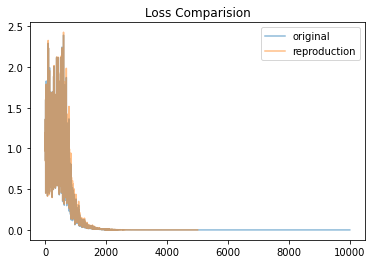

In [258]:
plt.figure()
plt.rcParams['figure.facecolor'] = 'white'
plt.title("Loss Comparision")
plt.plot(np.arange(len(losses)), losses, label = "original", alpha=0.5)
plt.plot(np.arange(len(losses_)), losses_, label = "reproduction", alpha=0.5)
# plt.plot(np.arange(len(NALU.Superc.reinit_history)), NALU.Superc.reinit_history, label = "tmp", alpha=0.5)
plt.legend()
#plt.savefig("loss.png")

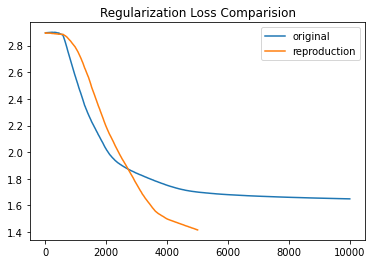

In [188]:
plt.rcParams['figure.facecolor'] = 'white'
plt.title("Regularization Loss Comparision")
plt.plot(np.arange(len(rlosses)), rlosses, label = "original")
plt.plot(np.arange(len(rlosses_)), rlosses_, label = "reproduction")
plt.legend()
#plt.savefig("loss_reg.png")

In [150]:
class NALU(tf.keras.layers.Layer):
    """Simplified NALU class to demonstrate lr problem."""

    @typechecked
    def __init__(
        self,
        input_dim: int,
        output_dim: int,
        w, m, g,
        *args,
        **kwargs,
    ):
        super(NALU, self).__init__(*args, **kwargs)

        self.input_dim = input_dim
        self.output_dim = output_dim
        

        # action variables
        self.w_hat = tf.Variable(w, trainable=True)

        self.m_hat = tf.Variable(m, trainable=True)

        # gating varaible
        self.g = tf.Variable(g, trainable=False)

    def call(self, input):
        eps = 1e-7
        w1 = tf.math.tanh(self.w_hat) * tf.math.sigmoid(self.m_hat)
        a1 = tf.matmul(input, w1)

        m1 = tf.math.exp(tf.minimum(tf.matmul(tf.math.log(tf.maximum(tf.math.abs(input), eps)),w1), 20))
        
        # sign
        w1s = tf.math.abs(tf.reshape(w1, [-1]))
        xs = tf.concat([input] * w1.shape[1], axis=1)
        xs = tf.reshape(xs, shape=[-1, w1.shape[0] * w1.shape[1]])
        sgn = tf.sign(xs) * w1s + (1 - w1s)
        sgn = tf.reshape(sgn, shape=[-1, w1.shape[1], w1.shape[0]])
        ms = tf.math.reduce_prod(sgn, axis=2)
        
        g1 = tf.math.sigmoid(self.g)
        return g1 * a1 + (1 - g1) * m1 * tf.clip_by_value(ms, -1, 1)

model = NALU(2, 1, w, m, g)

loss_fn = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE)

learning_rate = 0.01

optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate, epsilon = 1e-10)

def regularize(var):
    return 1 * tf.maximum(tf.minimum(-var, var) + 20, 0)


@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        logits = model(x, training=True)
        loss_value = loss_fn(y, logits)
    erloss = 0.05 * tf.add_n([tf.reduce_mean(regularize(v)) for v in model.trainable_weights + [model.g]])
    grads = tape.gradient(loss_value, model.trainable_weights)
    grads = [tf.clip_by_value(g, -0.1, 0.1) for g in grads]
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    return logits, loss_value, erloss

@tf.function
def train_step_gate(x, y):
    with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch(model.g)
        logits = model(x, training=True)
        loss_value = loss_fn(y, logits)
    grads = tape.gradient(loss_value, [model.g])
    erloss = 0.05 * tf.add_n([tf.reduce_mean(regularize(v)) for v in model.trainable_weights + [model.g]])
    grads = [tf.clip_by_value(g, -0.1, 0.1) for g in grads]
    optimizer.apply_gradients(zip(grads, [model.g]))
    return logits, loss_value, erloss


@tf.function
def predict(x, y):
    logits = model(x, training=False)
    loss_value = loss_fn(y, logits)
    erloss = 0.05 * tf.add_n([tf.reduce_mean(regularize(v)) for v in model.trainable_weights + [model.g]])
    return logits, loss_value, erloss


In [151]:
losses_ = []
rlosses_ = []
ext_loss_ = []
int_loss_ = []
rext_loss_ = []
rint_loss_ = []


batch_size = 64

for epoch in range(5):
    print(epoch)
    i = 0 
    while i< len(data):
        x = data[i:i + batch_size, :]
        y = lbls[i:i + batch_size, :]
        if (i // batch_size) % 10 < 8:
            tmpres, loss_value, reg_loss = train_step(x, y)
        else:
            tmpres, loss_value, reg_loss = train_step_gate(x, y)

        losses_.append(loss_value)
        rlosses_.append(reg_loss)
        i+=batch_size

        if (i // batch_size) % 1000 == 0:
            _, eloss_ex, erloss_ex = predict(ext_data, ext_lbls)
            _, eloss_in, erloss_in = predict(int_data, int_lbls)

            ext_loss_.append(eloss_ex)
            rext_loss_.append(erloss_ex)
            int_loss_.append(eloss_in)
            rint_loss_.append(erloss_in)

0
1
2
3
4


In [152]:
losses_ = list(map(lambda x : x.numpy(), losses_))
rlosses_ = list(map(lambda x : x.numpy(), rlosses_))
ext_loss_ = list(map(lambda x: x.numpy(), ext_loss_))
rext_loss_ = list(map(lambda x: x.numpy(), rext_loss_))
int_loss_ = list(map(lambda x: x.numpy(), int_loss_))
rint_loss_ = list(map(lambda x: x.numpy(), rint_loss_))

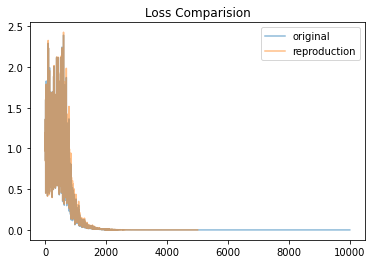

In [153]:
plt.figure()
plt.rcParams['figure.facecolor'] = 'white'
plt.title("Loss Comparision")
plt.plot(np.arange(len(losses)), losses, label = "original", alpha=0.5)
plt.plot(np.arange(len(losses_)), losses_, label = "reproduction", alpha=0.5)
plt.legend()
#plt.savefig("loss.png")

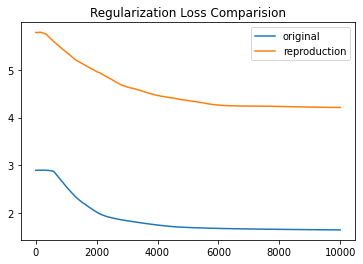

In [132]:
plt.rcParams['figure.facecolor'] = 'white'
plt.title("Regularization Loss Comparision")
plt.plot(np.arange(len(rlosses)), rlosses, label = "original")
plt.plot(np.arange(len(rlosses_)), rlosses_, label = "reproduction")
plt.legend()
#plt.savefig("loss_reg.png")

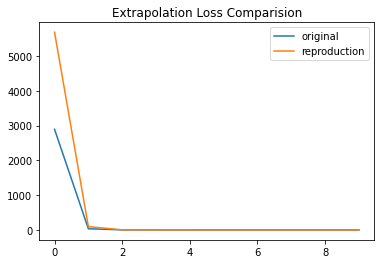

In [133]:
plt.rcParams['figure.facecolor'] = 'white'
plt.title("Extrapolation Loss Comparision")
plt.plot(np.arange(len(ext_loss)), ext_loss, label = "original")
plt.plot(np.arange(len(ext_loss_)), ext_loss_, label = "reproduction")
plt.legend()
#plt.savefig("ext_loss.png")

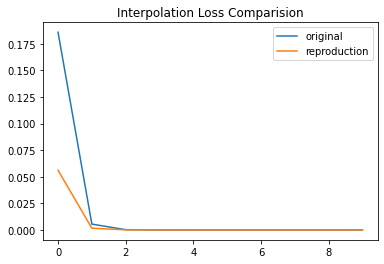

In [134]:
plt.rcParams['figure.facecolor'] = 'white'
plt.title("Interpolation Loss Comparision")
plt.plot(np.arange(len(int_loss)), int_loss, label = "original")
plt.plot(np.arange(len(int_loss_)), int_loss_, label = "reproduction")
plt.legend()
#plt.savefig("int_loss.png")

In [ ]:

# metrtics = mm.fit(
#     data_dp,
#     epochs = epochs, 
#     batch_size = batch_size,
#     callbacks=[
#         NALU.Superc(ext_data_dp, ext_lbls,
#                     int_data_dp, int_lbls,
#                     fr_param_check=10000,
#                     epochs_to_reg = 10
#                     )
#         ])



# loss_fn = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE)

# learning_rate = 0.01

# optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate, epsilon = 1e-10)

# def regularize(var):
#     return 1 * tf.maximum(tf.minimum(-var, var) + 20, 0)


# @tf.function
# def train_step(x, y):
#     with tf.GradientTape() as tape:
#         logits = model(x, training=True)
#         loss_value = loss_fn(y, logits)
#     erloss = 0.05 * tf.add_n([tf.reduce_mean(regularize(v)) for v in model.trainable_weights + [model.layers[0].g, model.layers[1].g]])
#     grads = tape.gradient(loss_value, model.trainable_weights)
#     grads = [tf.clip_by_value(g, -0.1, 0.1) for g in grads]
#     optimizer.apply_gradients(zip(grads, model.trainable_weights))
#     return logits, loss_value, erloss

# @tf.function
# def train_step_gate(x, y):
#     with tf.GradientTape(watch_accessed_variables=False) as tape:
#         tape.watch(model.layers[0].g)
#         tape.watch(model.layers[1].g)

#         logits = model(x, training=True)
#         loss_value = loss_fn(y, logits)
#     grads = tape.gradient(loss_value, [model.layers[0].g, model.layers[1].g])
#     erloss = 0.05 * tf.add_n([tf.reduce_mean(regularize(v)) for v in model.trainable_weights + [model.layers[0].g, model.layers[1].g]])
#     grads = [tf.clip_by_value(g, -0.1, 0.1) for g in grads]
#     optimizer.apply_gradients(zip(grads, tape.watched_variables()))
#     return logits, loss_value, erloss


# @tf.function
# def predict(x, y):
#     logits = model(x, training=False)
#     loss_value = loss_fn(y, logits)
#     erloss = 0.05 * tf.add_n([tf.reduce_mean(regularize(v)) for v in model.trainable_weights + [model.layers[0].g, model.layers[1].g]])
#     return logits, loss_value, erloss



In [103]:
grads_ = None
class NALUModelSuper(tf.keras.Model):

    def __init__(self, *args, **kwargs):
        super(NALUModelSuper, self).__init__(*args, **kwargs)
        self.steps_counter = tf.Variable(0, trainable=False)
        self.epoch_counter = tf.Variable(0, trainable=False)
        self.reinitialization_counter = tf.Variable(0, trainable=False)
        self.regularize = tf.Variable(False, trainable=False)
        self.gating = tf.Variable(False, trainable=False)
        self.gate_var = None

    def reinitialise(self):
        for l in self.layers:
            if isinstance(l, NALU):
                l.reinitialise()


    def get_gates_variables(self) -> List[tf.Variable]:
        return [l.g for l in self.layers if isinstance(l, NALU)]

    def get_regularization_loss(self):
        # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        # inspect if reduce_sum is good reducer !!!!!
        # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        return tf.math.reduce_sum(self.losses)

    @tf.function
    def train_step_active(self, data):
        x, y = data
        with tf.GradientTape(watch_accessed_variables = True) as tape:
            logits = self(x, training=True) 
            loss_value = self.compiled_loss(y, logits)
            # loss_value = tf.math.add(loss_value, tf.cond(
            #     tf.math.logical_and(self.regularize, tf.math.less(loss_value, 1.0)),
            #     lambda: self.get_regularization_loss(), 
            #     lambda: tf.constant(0, dtype = tf.float32)))
        
        rloss = self.get_regularization_loss()
        grads = tape.gradient(loss_value, tape.watched_variables())
        clipped_grads = [tf.clip_by_value(grad, -0.1, 0.1) for grad in grads]
        self.optimizer.apply_gradients(zip(clipped_grads, tape.watched_variables()))
        self.compiled_metrics.update_state(y, logits)
        return  {**{m.name: m.result() for m in self.metrics}, **{"rloss": rloss}}
        #return loss_value, rloss

    @tf.function
    def train_step_gating(self, data):
        if not self.gate_var:
            self.gate_var = self.get_gates_variables()
        x, y = data
        with tf.GradientTape(watch_accessed_variables = False) as tape:
            for v in self.gate_var:
                tape.watch(v)
            logits = self(x, training=True) 
            loss_value = self.compiled_loss(y, logits)
            # loss_value = tf.math.add(loss_value, tf.cond(
            #     tf.math.logical_and(self.regularize, tf.math.less(loss_value, 1.0)),
            #     lambda: self.get_regularization_loss(), 
            #     lambda: tf.constant(0, dtype = tf.float32)))

        rloss = self.get_regularization_loss()

        grads = tape.gradient(loss_value, tape.watched_variables())
        
        clipped_grads = [tf.clip_by_value(grad, -0.1, 0.1) for grad in grads]
        self.optimizer.apply_gradients(zip(clipped_grads, tape.watched_variables()))
        self.compiled_metrics.update_state(y, logits)
        return  {**{m.name: m.result() for m in self.metrics}, **{"rloss": rloss}}
        #return loss_value, rloss


    @tf.function
    def train_step(self, data):
        """
        Specifying tf.function(input_signature=...) slows down the computation, but it leads to greater control:
        https://www.neuralconcept.com/post/in-graph-training-loop
        
        """

        return tf.cond(self.gating, 
            lambda: self.train_step_active(data),
            lambda: self.train_step_gating(data))


g_initializer = tf.random_normal_initializer(mean=0, stddev=0.1, seed=args.seed)
w_initializer = tf.random_normal_initializer(mean=1, stddev=0.1, seed=args.seed)
m_initializer = tf.random_normal_initializer(mean=-1, stddev=0.1, seed=args.seed)

class NALUModel(NALUModelSuper):

    def __init__(self, *args, **kwargs):
        super(NALUModel, self).__init__(*args, **kwargs)
        
        self.layer = NALU(1, 
            gate_as_vector = True,
            clipping = 20, 
            force_operation = None, 
            weights_separation = False,
            input_gate_dependance = False,
            g_initializer = g_initializer,
            w_initializer = w_initializer,
            m_initializer = m_initializer,
            )

    def call(self, inputs: tf.Tensor, training: bool = True):
        return self.layer(inputs)
    

In [104]:
mm = NALUModel()
mm.compile(optimizer=
    tf.keras.optimizers.Adam(learning_rate=0.01), 
    loss="mse", 
    metrics=["mae"])
# print(mm.variables)
batch_size = 64
epochs = 10
metrtics = mm.fit(
    data_dp,
    epochs = epochs, 
    batch_size = batch_size,
    callbacks=[
        NALU.Superc(ext_data, ext_lbls,
                    int_data, int_lbls,
                    fr_param_check=100000,
                    epochs_to_reg = 10
                    )
        ])

Epoch 1/10
1000/1000 [==============================] - 6s 3ms/step - loss: 0.9978 - mae: 0.6580 - rloss: 2.8472
Epoch 2/10
1000/1000 [==============================] - 3s 3ms/step - loss: 0.9532 - mae: 0.6311 - rloss: 2.7755
Epoch 3/10
1000/1000 [==============================] - 3s 3ms/step - loss: 0.9506 - mae: 0.6281 - rloss: 2.7427
Epoch 4/10
1000/1000 [==============================] - 3s 3ms/step - loss: 0.9500 - mae: 0.6272 - rloss: 2.7188
Epoch 5/10
1000/1000 [==============================] - 3s 3ms/step - loss: 0.9497 - mae: 0.6268 - rloss: 2.6976
Epoch 6/10
1000/1000 [==============================] - 4s 4ms/step - loss: 0.9495 - mae: 0.6266 - rloss: 2.6774
Epoch 7/10
1000/1000 [==============================] - 4s 4ms/step - loss: 0.9494 - mae: 0.6264 - rloss: 2.6582
Epoch 8/10
1000/1000 [==============================] - 4s 4ms/step - loss: 0.9493 - mae: 0.6263 - rloss: 2.6397
Epoch 9/10
1000/1000 [==============================] - 5s 5ms/step - loss: 0.9492 - mae: 0.6262

In [54]:
extd = NALU.Superc.ext_res
intd = NALU.Superc.int_res
intd

[<tf.Tensor: shape=(), dtype=float64, numpy=0.9614680938878262>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.9550751295040427>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.954067564306282>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.9536642955600512>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.9534573460940649>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.9533250737262351>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.9532403347573465>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.9531843862423074>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.9531429190711124>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.9531101578603071>]

In [55]:
extd

[<tf.Tensor: shape=(), dtype=float64, numpy=24469.91134523181>,
 <tf.Tensor: shape=(), dtype=float64, numpy=24596.39121153786>,
 <tf.Tensor: shape=(), dtype=float64, numpy=24606.898292530987>,
 <tf.Tensor: shape=(), dtype=float64, numpy=24611.339225820666>,
 <tf.Tensor: shape=(), dtype=float64, numpy=24614.15459373429>,
 <tf.Tensor: shape=(), dtype=float64, numpy=24618.976719005503>,
 <tf.Tensor: shape=(), dtype=float64, numpy=24624.799643610604>,
 <tf.Tensor: shape=(), dtype=float64, numpy=24630.07886214708>,
 <tf.Tensor: shape=(), dtype=float64, numpy=24634.073866078794>,
 <tf.Tensor: shape=(), dtype=float64, numpy=24637.1320274451>]

In [27]:
import csv

In [33]:
with open("int_data.csv", "w") as f:
    write = csv.writer(f)
    for x in intd:
        write.writerow([x.numpy()])



In [173]:
seed = args.seed
g_intializer = tf.random_normal_initializer(mean=0, stddev=0.1, seed=seed)
w_intializer = tf.random_normal_initializer(mean=1, stddev=0.1, seed=seed)
m_intializer = tf.random_normal_initializer(mean=-1, stddev=0.1, seed=seed)
batch_size = 64
clipping = 20
lr = 0.01
reg_coef = 0.05

tmp = None


class Superc(tf.keras.callbacks.Callback):

    def __init__(self, 
        epochs_to_reg: int = 5, 
        lt_to_reg: float = 1.0, 
        fr_param_check: int = 1500,
        *args, **kwargs):
        
        super(Superc, self).__init__(*args, **kwargs)
        Superc.epochs_to_reg = 5
        Superc.lt_to_reg = lt_to_reg
        Superc.fr_param_check = fr_param_check
    
    def on_train_begin(self, logs = None):
        Superc.reinit_history = []
        Superc.reinit_counter = 0
        Superc._steps_counter = 0
        Superc._epoch_counter = 0

    # delay regularize
    def on_train_epoch_end(self, epoch, logs = None):
        Superc._epoch_counter += 1

    def on_train_batch_end(self, batch, logs = None):
        
        Superc._steps_counter += 1
        
        # record last loss
        Superc.reinit_history.append(logs.get("loss"))

        # train either active or gating
        self.model.gating.assign(Superc._steps_counter % 10 < 8)

        # turn on or of ragularization depending on epoch number and last seen loss
        self.model.regularize.assign(Superc._epoch_counter > Superc.epochs_to_reg and Superc.reinit_history[-1] < Superc.lt_to_reg)


        # reinitialisation strategy
        split_index = len(Superc.reinit_history)//2
        if len(Superc.reinit_history)>10000 \
            and Superc._epoch_counter > 0 \
            and Superc._epoch_counter%10==1 \
            and tf.math.reduce_mean(Superc.reinit_history[:split_index]) <= tf.math.add(
                        tf.math.reduce_mean(Superc.reinit_history[split_index:]),
                        tf.math.reduce_std(Superc.reinit_history[split_index:])
                        ) \
            and tf.math.reduce_mean(Superc.reinit_history[split_index:]) > 1:
            # reinitialize all nalu layers 
            self.model.reinitialise()
            Superc.reinit_history = []
            Superc.reinit_counter += 1

        # check parameters
        if self._steps_counter % Superc.fr_param_check == 0:
            tf.print("\n--- Parameter Check Start---")
            eloss_ex = self.model.compiled_loss._losses[0](self.model.predict(ext_data_dp, verbose = 1), ext_lbls)
            eloss_in = self.model.compiled_loss._losses[0](self.model.predict(int_data_dp, verbose = 1), int_lbls)
            tf.print("--- Parameter Check End---")

        


In [9]:
     
mm = NALUModel()
mm.compile(optimizer="adam", loss="mse", metrics=["mae"])
# print(mm.variables)

metrtics = mm.fit(
    data_dp,
    epochs = 3, 
    batch_size = batch_size, 
    callbacks=[
        NALU.Superc()
        ])


In [10]:
# garbage collector

In [11]:
NALU.Superc.reinit_history[-1]


AttributeError: type object 'Superc' has no attribute 'reinit_history'

In [12]:
tmp.x

NameError: name 'tmp' is not defined

In [13]:
# with open("%s.csv" % "_".join([args.output, args.nalu, args.dist, str(args.params), str(args.ext), str(args.seed), args.op, "int"]), "w") as intlog:
#     with open("%s.csv" % "_".join([args.output, args.nalu, args.dist, str(args.params), str(args.ext), str(args.seed), args.op, "ext"]), "w") as extlog:
losses = []
reinitctr = 0
REGULARIZATION = True
for epoch in range(10):
    print("Epoch:",epoch)
    for i, data in enumerate(data_dp):
        if i % 10 < 8:
            loss_value = mm.train_step_active(data)["loss"]
        else:
            loss_value = mm.train_step_gating(data)["loss"]

        if REGULARIZATION:
            if epoch > 10 and loss_value < 1:
                mm.regularize.assign(True)
                loss_value = mm.train_step_active(data)["loss"]
                loss_value = mm.train_step_gating(data)["loss"]
            else:
                mm.regularize.assign(False)
        losses.append(loss_value)

        # reinitialisation strategy
        split_index = len(losses)//2
        if split_index>10000//BATCH_SIZE \
            and epoch > 0 \
            and epoch%10==1 \
            and tf.math.reduce_mean(losses[:split_index]) <= tf.math.add(
                        tf.math.reduce_mean(losses[split_index:]),
                        tf.math.reduce_std(losses[split_index:])
                        ) \
            and tf.math.reduce_mean(losses[split_index:]) > 1:
            mm.reinitialise()
            losses = []
            reinitctr += 1

        if i%1000 == 0:
            eloss_ex = mm.compiled_loss._losses[0](mm.predict(ext_data), ext_lbls) # np.mean([mm.test_step(x)["loss"] for x in ext_data_dp])
            print(eloss_ex)
            # eloss_in = np.mean([mm.test_step(x)["loss"] for x in int_data_dp])

            # print("int loss: {:.5E}\tregularization-loss: {:.5E}".format(eloss_in, erloss_in))
            
            # intlog.write("\t".join([str(epoch), str(i), args.output, args.nalu, args.dist, str(args.params), str(args.ext), str(args.seed), args.op, "{:.5E}".format(eloss), "{:.5E}".format(eloss_in), str(reinitctr)])+"\n")
            # extlog.write("\t".join([str(epoch), str(i), args.output, args.nalu, args.dist, str(args.params), str(args.ext), str(args.seed), args.op, "{:.5E}".format(eloss), "{:.5E}".format(eloss_ex), str(reinitctr)]) + "\n")


Epoch: 0
2000/2000 [==============================] - 5s 2ms/step
tf.Tensor(21808.44438777578, shape=(), dtype=float64)
Epoch: 1
2000/2000 [==============================] - 4s 2ms/step
tf.Tensor(22684.224431035356, shape=(), dtype=float64)
Epoch: 2
2000/2000 [==============================] - 4s 2ms/step
tf.Tensor(22607.82863809394, shape=(), dtype=float64)
Epoch: 3
2000/2000 [==============================] - 4s 2ms/step
tf.Tensor(22362.5936101301, shape=(), dtype=float64)
Epoch: 4
2000/2000 [==============================] - 4s 2ms/step
tf.Tensor(22144.852752745664, shape=(), dtype=float64)
Epoch: 5
2000/2000 [==============================] - 4s 2ms/step
tf.Tensor(21976.898584666094, shape=(), dtype=float64)
Epoch: 6
2000/2000 [==============================] - 4s 2ms/step
tf.Tensor(21846.49514842637, shape=(), dtype=float64)
Epoch: 7
2000/2000 [==============================] - 4s 2ms/step
tf.Tensor(21735.00620283161, shape=(), dtype=float64)
Epoch: 8
1000/1000 [==================

TypeError: 'BatchDataset' object is not subscriptable

In [38]:

#  PREVIOUS CALLBACK KEEP FOR INSPECTION

class DelayRegularize(tf.keras.callbacks.Callback):
    regularize_epochs = 5    
    def on_epoch_end(self, epoch, logs=None):
        tf.cond(tf.math.greater(epoch, DelayRegularize.regularize_epochs), lambda: self.model.regularize.assign(True), lambda: None)
        

class ReinitializatoinControll(tf.keras.callbacks.Callback):

    history = []
    counter = 0
    
    def on_train_batch_end(self, batch, logs=None):
        ReinitializatoinControll.history.append(logs.get("loss"))
    

    def on_epoch_end(self, epoch, logs=None):
        split_index = len(ReinitializatoinControll.history)//2
        if split_index>500 \
            and epoch > 0 \
            and epoch%10==1 \
            and tf.math.reduce_mean(self.history[:split_index]) <= tf.math.add(
                        tf.math.reduce_mean(self.history[split_index:]),
                        tf.math.reduce_std(self.history[split_index:])
                        ) \
            and tf.math.reduce_mean(ReinitializatoinControll.history[split_index:]) > 1:
            self.model.reinitialise()
            ReinitializatoinControll.history = []
            ReinitializatoinControll.counter += 1


class Evaluator(tf.keras.callbacks.Callback):
    history = []
    def on_test_batch_end(self, epoch, logs = None):
        if tf.math.mod(self.model.steps_counter, 10)==0:
            Evaluator.history.append(logs.get("loss"))

class EXTCSV(tf.keras.callbacks.Callback):
    counter = 0

    def on_train_begin(self, logs = None):
        pass
    
    def on_train_epoch_end(self, epoch, logs = None):
        EXTCSV.counter = epoch

    def on_train_batch_end(self, batch, logs = None):
        if EXTCSV.counter*64 + batch

<tf.Tensor: shape=(), dtype=bool, numpy=True>